# TIME SERIES ANALYSIS FOR CRAIGSLIST VEHICLES

## Import the necessary libraries

In [1]:
# Data loading
import pandas as pd

# Data manipulation
import numpy as np

# Data visualisation
%matplotlib inline
import matplotlib.pyplot as plt

# Time series models
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

# Handling warnings
import warnings
warnings.filterwarnings(action="ignore")

## Loading the dataset

In [2]:
df = pd.read_csv("C:/Users/ADMIN/OneDrive/Desktop/Mike/mydata/craigslist_vehicles.csv")
df.head()

,Unnamed: 0,id,url,region,region_url,price,year,manufacturer,model,condition,...,type,paint_color,image_url,description,county,state,lat,long,posting_date,removal_date
0,362773,7307679724,https://abilene.craigslist.org/ctd/d/abilene-2...,abilene,https://abilene.craigslist.org,4500,2002.0,bmw,x5,NaN,...,NaN,NaN,https://images.craigslist.org/00m0m_iba78h8ty9...,"$4,500 Cash 2002 BMW X5 8 cylinder 4.4L moto...",NaN,tx,32.401556,-99.884713,2021-04-16 00:00:00+00:00,2021-05-02 00:00:00+00:00
1,362712,7311833696,https://abilene.craigslist.org/ctd/d/abilene-2...,abilene,https://abilene.craigslist.org,4500,2002.0,bmw,x5,NaN,...,NaN,NaN,https://images.craigslist.org/00m0m_iba78h8ty9...,"$4,500 Cash 2002 BMW X5 8 cylinder 4.4L moto...",NaN,tx,32.401556,-99.884713,2021-04-24 00:00:00+00:00,2021-04-28 00:00:00+00:00
2,362722,7311441996,https://abilene.craigslist.org/ctd/d/abilene-2...,abilene,https://abilene.craigslist.org,4900,2006.0,toyota,camry,excellent,...,sedan,silver,https://images.craigslist.org/00808_5FkOw2aGjA...,2006 TOYOTA CAMRY LE Sedan Ready To Upgrade ...,NaN,tx,32.453848,-99.787900,2021-04-23 00:00:00+00:00,2021-05-25 00:00:00+00:00
3,362771,7307680715,https://abilene.craigslist.org/ctd/d/abilene-2...,abilene,https://abilene.craigslist.org,6500,2008.0,ford,expedition,NaN,...,NaN,NaN,https://images.craigslist.org/00M0M_i9CoFvVq8o...,$6500.00 2008 Ford Expedition 8 cylinder 5.4L...,NaN,tx,32.401556,-99.884713,2021-04-16 00:00:00+00:00,2021-04-26 00:00:00+00:00
4,362710,7311834578,https://abilene.craigslist.org/ctd/d/abilene-2...,abilene,https://abilene.craigslist.org,6500,2008.0,ford,expedition,NaN,...,NaN,NaN,https://images.craigslist.org/00M0M_i9CoFvVq8o...,$6500.00 2008 Ford Expedition 8 cylinder 5.4L...,NaN,tx,32.401556,-99.884713,2021-04-24 00:00:00+00:00,2021-05-12 00:00:00+00:00


## Data Pre-Processing

In [3]:
df.shape 

(426880, 28)

In [4]:
# Displaying the data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 28 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    426880 non-null  int64  
 1   id            426880 non-null  int64  
 2   url           426880 non-null  object 
 3   region        426880 non-null  object 
 4   region_url    426880 non-null  object 
 5   price         426880 non-null  int64  
 6   year          425675 non-null  float64
 7   manufacturer  409234 non-null  object 
 8   model         421603 non-null  object 
 9   condition     252776 non-null  object 
 10  cylinders     249202 non-null  object 
 11  fuel          423867 non-null  object 
 12  odometer      422480 non-null  float64
 13  title_status  418638 non-null  object 
 14  transmission  424324 non-null  object 
 15  VIN           265838 non-null  object 
 16  drive         296313 non-null  object 
 17  size          120519 non-null  object 
 18  type

In [5]:
# Checking for missing values in the data
df.isnull().sum()

Unnamed: 0           0
id                   0
url                  0
region               0
region_url           0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
image_url           68
description         70
county          426880
state                0
lat               6549
long              6549
posting_date        68
removal_date        68
dtype: int64

In [6]:
# Separating categorical and numerical columns
numerical_cols = df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(exclude=['number']).columns

#### Handling the missing values for both numerical columns and categorical columns where we fill the null rows of numerical columns with median and fill the null rows of categorical columns with mode

In [7]:
# Fill missing values in numerical columns with the median
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Fill missing values in categorical columns with the mode
for col in categorical_cols:
    mode_val = df[col].mode().iloc[0]  # Calculate the mode value
    df[col].fillna(mode_val, inplace=True)

In [8]:
# Checking the succes of the method
df.isnull().sum()

Unnamed: 0           0
id                   0
url                  0
region               0
region_url           0
price                0
year                 0
manufacturer         0
model                0
condition            0
cylinders            0
fuel                 0
odometer             0
title_status         0
transmission         0
VIN                  0
drive                0
size                 0
type                 0
paint_color          0
image_url            0
description          0
county          426880
state                0
lat                  0
long                 0
posting_date         0
removal_date         0
dtype: int64

In [9]:
# Convert the 'Month' column to a datetime object
df['posting_date'] = pd.to_datetime(df['posting_date'])

In [10]:
# Sort the DataFrame by date in ascending order
df.sort_values(by='posting_date', inplace=True)
df.reset_index(drop=True, inplace=True)

In [11]:
# Checking for duplicates in the dataframe
df['posting_date'].duplicated()

0         False
1          True
2          True
3          True
4          True
          ...  
426875     True
426876     True
426877     True
426878     True
426879     True
Name: posting_date, Length: 426880, dtype: bool

In [12]:
# Dropping the duplicated data in the posting_date column
df = df.drop_duplicates(subset='posting_date', keep='first')

In [13]:
# Set the 'Month' column as the index
df.set_index('posting_date', inplace=True)


## Descriptive analysis for the price

In [14]:
# Calculating the mean and the standard deviation
mean_price = df['price'].mean()
std_price = df['price'].std()

print("Mean Price:", mean_price)
print("Standard Deviation of price:", std_price)

Mean Price: 16533.59375
Standard Deviation of price: 11349.128054781595


## Time Series Original Visualization

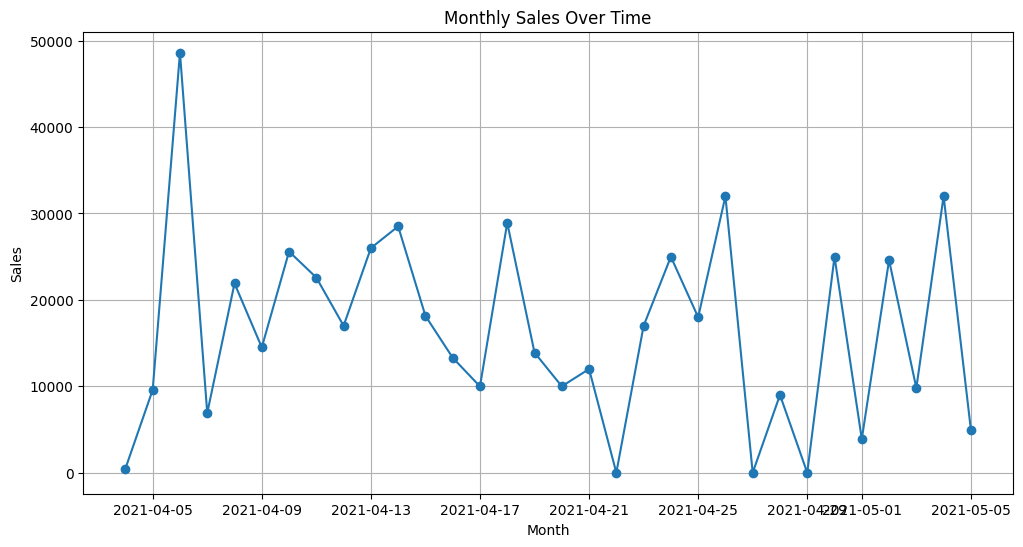

In [15]:
# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['price'], marker='o', linestyle='-')
plt.title('Monthly Sales Over Time')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True)

## Time series Decomposition and Visualization

In [16]:
# Perform time series decomposition
decomposition = sm.tsa.seasonal_decompose(df['price'], model='additive',period=12)

In [17]:
# Plot the original time series, trend, seasonality, and residuals
plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

Text(0.5, 1.0, 'Original Time Series')

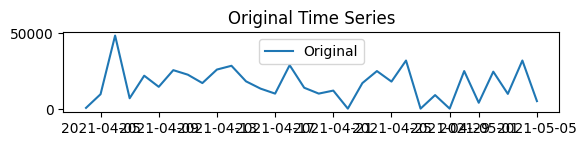

In [18]:
plt.subplot(4, 1, 1)
plt.plot(df.index, df['price'], label='Original')
plt.legend()
plt.title('Original Time Series')

Text(0.5, 1.0, 'Trend Component')

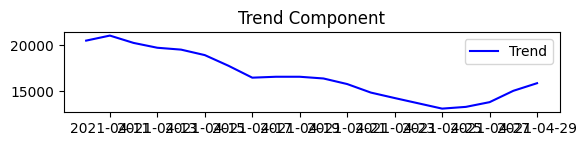

In [19]:
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='b')
plt.legend()
plt.title('Trend Component')

Text(0.5, 1.0, 'Seasonal Component')

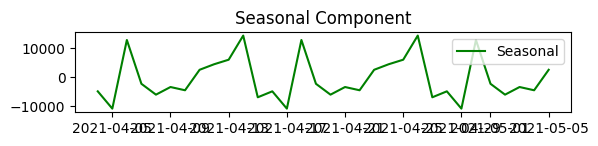

In [20]:
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal', color='g')
plt.legend()
plt.title('Seasonal Component')

Text(0.5, 1.0, 'Residual Component')

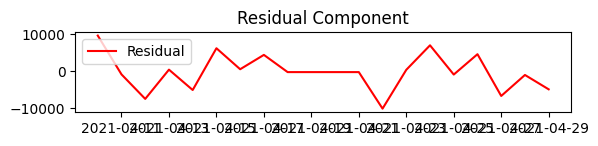

In [21]:
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual', color='r')
plt.legend()
plt.title('Residual Component')

## Checking for stationarity in the price 

In [22]:
# Check for stationarity
result = adfuller(df['price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -3.627799036348426
p-value: 0.005251276983009179


#### Since the p-value is approximately 0.005, the data is stationary

## PLot ACF and PACF to find p and q 

<Figure size 1000x400 with 0 Axes>

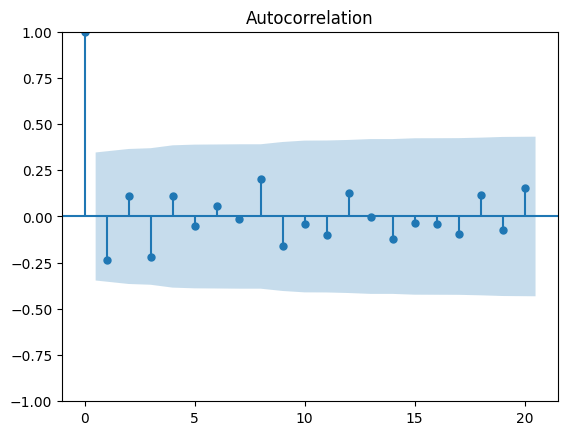

In [23]:
# Plotting ACF 
plt.figure(figsize=(10, 4))
plot_acf(df['price'], lags=20)
plt.show()

<Figure size 1000x400 with 0 Axes>

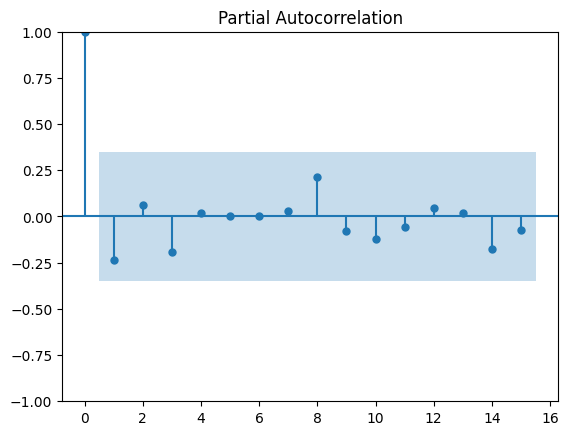

In [24]:
# Plotting PACF
plt.figure(figsize=(10, 4))
plot_pacf(df['price'], lags=15)
plt.show()

## The ARIMA Model

In [25]:
df.sort_values(by='posting_date', inplace=True)
df.reset_index(drop=True, inplace=True)

In [26]:
p = 1 # p: AutoRegressive (AR) order
d = 1 # d: Integrated (I) order (order of differencing)
q = 1 # q: Moving Average (MA) order

In [27]:
# Fit an ARIMA model to the data
model = sm.tsa.ARIMA(df['price'], order=(p, d, q))

In [28]:
results = model.fit()

In [29]:
# Print the model summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                   32
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -335.462
Date:                Tue, 21 May 2024   AIC                            676.923
Time:                        23:29:10   BIC                            681.225
Sample:                             0   HQIC                           678.325
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1607      0.299     -0.538      0.591      -0.746       0.425
ma.L1         -1.0000      0.184     -5.426      0.000      -1.361      -0.639
sigma2      1.334e+08   1.38e-09   9.66e+16      0.0

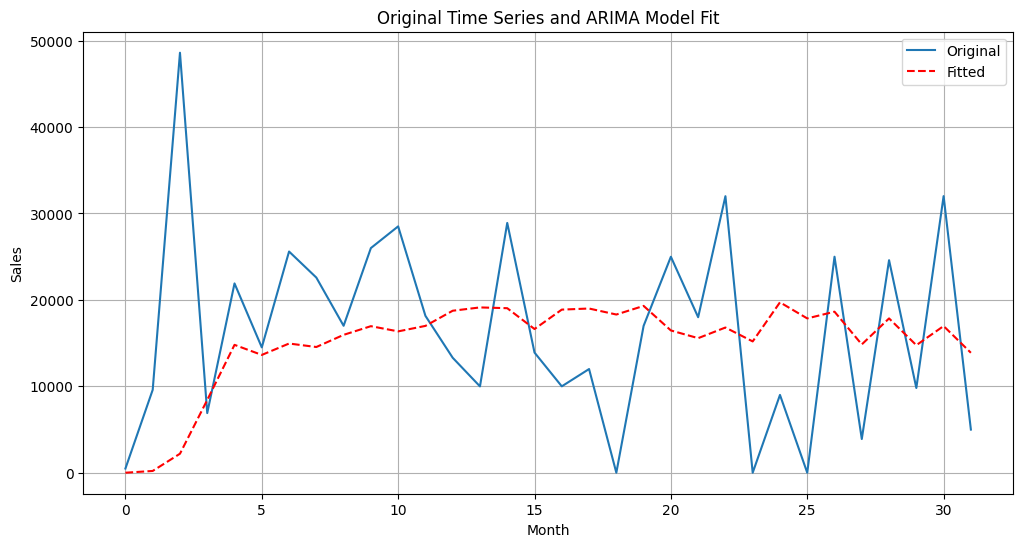

In [30]:
# Plot the original time series and the ARIMA model's predictions
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['price'], label='Original')
plt.plot(df.index, results.fittedvalues, color='red', label='Fitted', linestyle='--')
plt.legend()
plt.title('Original Time Series and ARIMA Model Fit')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True)

# Display the plot
plt.show()

## Forecasting future values 

In [31]:
frequency = 'M'

In [32]:
# Forecast future values
forecast_periods = 12  # Change the number of forecast periods as needed
forecast = results.get_forecast(steps=forecast_periods)

In [33]:
# Extract forecasted values and confidence intervals
forecasted_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

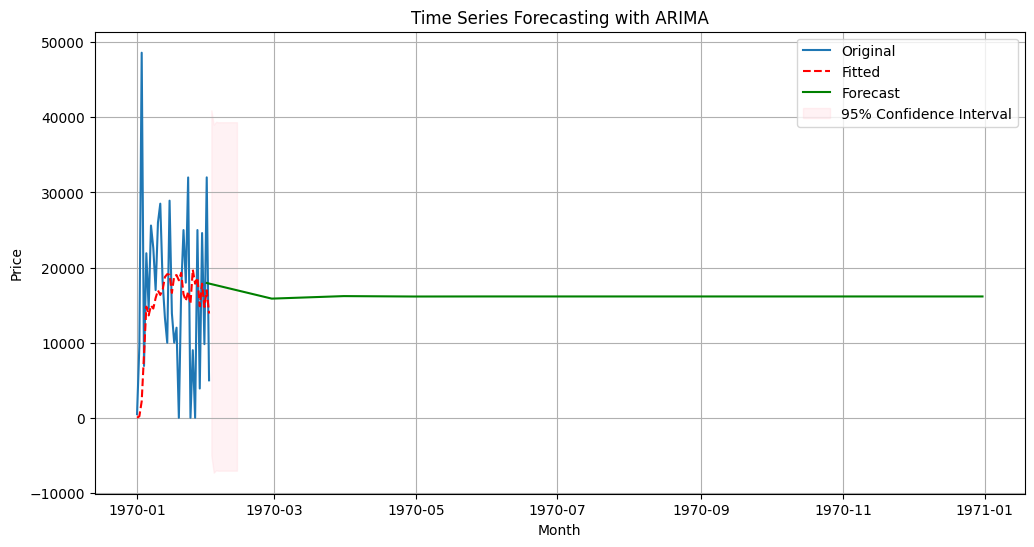

In [34]:
# Plot the original time series, ARIMA model's fitted values, and forecasts
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['price'], label='Original')
plt.plot(df.index, results.fittedvalues, color='red', label='Fitted', linestyle='--')
plt.plot(pd.date_range(start=df.index[-1], periods=forecast_periods, freq=frequency), forecasted_values, color='green', label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.title('Time Series Forecasting with ARIMA')
plt.xlabel('Month')
plt.ylabel('Price')
plt.grid(True)

# Display the plot
plt.show()